In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the cleaned CSV data
df = pd.read_csv("cleaned_data.csv")


C:\Users\Anurag Lawaniya\AppData\Local\Temp\ipykernel_18052\2370556216.py:2: DtypeWarning: Columns (25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cleaned_data.csv")


In [3]:
grouped = df.groupby('wallet')

wallet_stats = pd.DataFrame()
wallet_stats['total_transactions'] = grouped.size()
wallet_stats['deposit_count'] = grouped['action'].apply(lambda x: (x == 'deposit').sum())
wallet_stats['borrow_count'] = grouped['action'].apply(lambda x: (x == 'borrow').sum())
wallet_stats['repay_count'] = grouped['action'].apply(lambda x: (x == 'repay').sum())
wallet_stats['liquidation_count'] = grouped['action'].apply(lambda x: (x == 'liquidationcall').sum())
wallet_stats['redeem_count'] = grouped['action'].apply(lambda x: (x == 'redeemunderlying').sum())

# Amount-based features
wallet_stats['total_amount'] = grouped['amount_eth'].sum()
wallet_stats['avg_amount'] = grouped['amount_eth'].mean()
wallet_stats['max_amount'] = grouped['amount_eth'].max()

# Behavior ratios
wallet_stats['repay_per_borrow'] = wallet_stats['repay_count'] / (wallet_stats['borrow_count'] + 1)
wallet_stats['liquidation_per_borrow'] = wallet_stats['liquidation_count'] / (wallet_stats['borrow_count'] + 1)

wallet_stats.fillna(0, inplace=True)


In [4]:
wallet_stats['credit_score'] = (
    wallet_stats['deposit_count'] * 1.2 +
    wallet_stats['repay_count'] * 2.0 +
    wallet_stats['redeem_count'] * 1.0 +
    wallet_stats['repay_per_borrow'] * 2.5 -
    wallet_stats['liquidation_per_borrow'] * 5.0 -
    wallet_stats['borrow_count'] * 0.5
)

# Normalize score to 0-1000 range
scaler = MinMaxScaler(feature_range=(0, 1000))
wallet_stats['credit_score'] = scaler.fit_transform(wallet_stats[['credit_score']])


In [5]:
features = wallet_stats.drop(columns=['credit_score'])
labels = wallet_stats['credit_score']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [6]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse:.2f}")

RMSE: 35.68


In [7]:
joblib.dump(model, "credit_score_model.pkl")
wallet_stats['predicted_score'] = model.predict(features)
wallet_stats['predicted_score'] = scaler.fit_transform(wallet_stats[['predicted_score']])
wallet_stats.reset_index().to_csv("wallets_with_scores.csv", index=False)


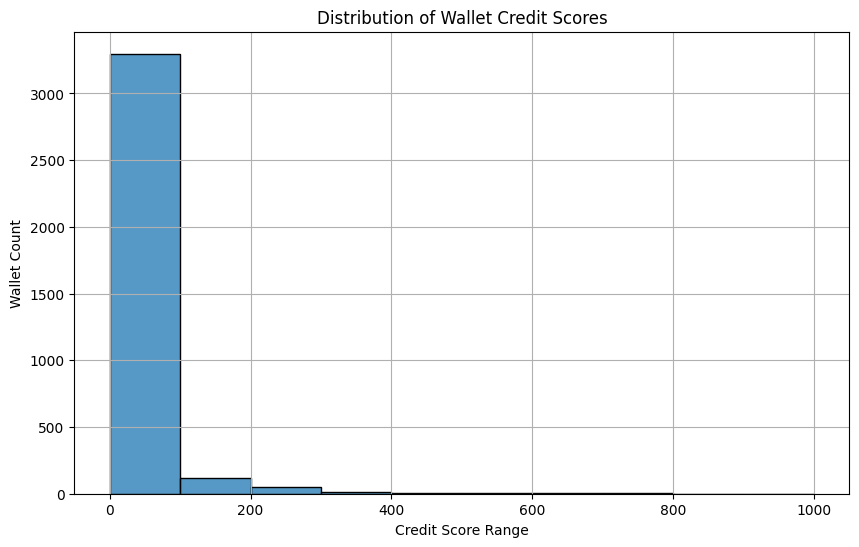

In [8]:
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
wallet_stats['score_bin'] = pd.cut(wallet_stats['predicted_score'], bins)

plt.figure(figsize=(10, 6))
sns.histplot(wallet_stats['predicted_score'], bins=bins, kde=False)
plt.title("Distribution of Wallet Credit Scores")
plt.xlabel("Credit Score Range")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.savefig("credit_score_distribution.png")
plt.show()